In [1]:
%pip install -q torch torchvision diffusers pillow accelerate matplotlib

Note: you may need to restart the kernel to use updated packages.


In [1]:
import math
import os
import json
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from PIL import Image
from diffusers import DDPMScheduler
from diffusers import DDPMPipeline
from diffusers.optimization import get_cosine_schedule_with_warmup
from diffusers import UNet2DConditionModel
from diffusers import UNet2DModel

from accelerate import Accelerator
from tqdm.auto import tqdm
from pathlib import Path

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [11]:
device = "cuda" if torch.cuda.is_available() else "mps"

In [3]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 128  # the generated image resolution
    train_batch_size = 8
    eval_batch_size = 4  # how many images to sample during evaluation
    num_epochs = 50
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 10
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "output/zizi-test-128"  # the model name locally and on the HF Hub
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0

In [4]:
config = TrainingConfig()

In [5]:
class ConditionalZiziDataset(Dataset):
    def __init__(self, input_dir, pose_dir):
        self.input_dir = input_dir
        self.pose_dir = pose_dir
        self.input_files = os.listdir(input_dir)
        self.preprocess = transforms.Compose(
            [
                transforms.Resize((config.image_size, config.image_size)),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5])
            ]
        )

    def __len__(self):
        return len(self.input_files)

    def _get_img(self, idx):
        img_dir = os.path.join(self.input_dir, self.input_files[idx])
        return self.preprocess(Image.open(img_dir).convert("RGB"))

    def _get_json(self, idx):
        input_split = os.path.splitext(self.input_files[idx])
        pose_json_name = input_split[0] + "_keypoints.json"
        json_dir = os.path.join(self.pose_dir, pose_json_name)
        with open(json_dir, 'r') as f:
            data = json.load(f)
        return torch.tensor(data['people'][0]['pose_keypoints_2d'])
    
    def __getitem__(self, idx):
        if isinstance(idx, slice):
            # Get the start, stop, and step from the slice
            return [self[ii] for ii in range(*idx.indices(len(self)))]

        input_img = self._get_img(idx)
        json_data = self._get_json(idx)

        return {
            "images": input_img,
            "poses": json_data
        }

In [6]:
dataset = ConditionalZiziDataset("data/meth-pose/test_img", "data/meth-pose/test_openpose")

In [7]:
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

In [17]:
model = UNet2DConditionModel(
    sample_size=config.image_size,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    encoder_hid_dim=75,
    cross_attention_dim=512,
    block_out_channels=(128, 256, 512, 512),
    mid_block_scale_factor=1,
    down_block_types=(
        "CrossAttnDownBlock2D",
        "CrossAttnDownBlock2D",
        "CrossAttnDownBlock2D",
        "DownBlock2D"
    ),
    up_block_types=(
        "UpBlock2D",
        "CrossAttnUpBlock2D",
        "CrossAttnUpBlock2D",
        "CrossAttnUpBlock2D"
    )
).to(device)

In [18]:
sample_image = dataset[0]["images"].unsqueeze(0).to(device)
sample_pose = dataset[0]["poses"].unsqueeze(0).to(device)

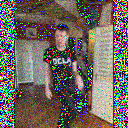

In [19]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise = torch.randn(sample_image.shape).to(device)
timesteps = torch.LongTensor([50]).to(device)
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

Image.fromarray(((noisy_image.cpu().permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

In [20]:
noise_pred = model(noisy_image, timesteps, sample_pose.view((1, 1, 75))).sample

RuntimeError: MPS backend out of memory (MPS allocated: 30.12 GB, other allocations: 82.93 MB, max allowed: 36.27 GB). Tried to allocate 8.00 GB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [13]:
loss = F.mse_loss(noise_pred, noise)

In [14]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

In [15]:
def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i % cols * w, i // cols * h))
    return grid


def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size=config.eval_batch_size,
        generator=torch.manual_seed(config.seed),
    ).images

    # Make a grid out of the images
    image_grid = make_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

In [16]:
def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )
    if accelerator.is_main_process:
        os.makedirs(config.output_dir, exist_ok=True)
        accelerator.init_trackers("train_example")

    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch["images"]
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device
            ).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            poses = batch["poses"].reshape((config.train_batch_size, 1, 75))

            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, poses, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                pipeline.save_pretrained(config.output_dir)

In [17]:
from accelerate import notebook_launcher

args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

notebook_launcher(train_loop, args, num_processes=1)

Launching training on one GPU.


/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:371: UserWarning: `log_with=tensorboard` was passed but no supported trackers are currently installed.
  warnings.warn(f"`log_with={log_with}` was passed but no supported trackers are currently installed.")


  0%|          | 0/543 [00:00<?, ?it/s]

KeyboardInterrupt: 